In [251]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import statsmodels.api as sm
import matplotlib

### Download geo assignment data and sales data file

In [252]:
geo_assignment = pd.read_csv("Geo_assignment.csv")

In [253]:
salesandcost= pd.read_csv("salesandcost.csv")

In [254]:
salesandcost['date'] = pd.to_datetime(salesandcost['date']) 

### Split into treatment and control based on random geo assignment data

In [255]:
salesandcost = salesandcost.merge(geo_assignment, on= 'geo')
salesandcost_control = salesandcost[salesandcost['geo.group']==1]
salesandcost_treatment = salesandcost[salesandcost['geo.group']==2]

### Compute total sales per day for treatment and control

In [256]:
salesandcost_control = salesandcost_control.groupby('date').sum('sales').reset_index()
salesandcost_treatment = salesandcost_treatment.groupby('date').sum('sales').reset_index()

### Plot sales per day data

<Axes: xlabel='date'>

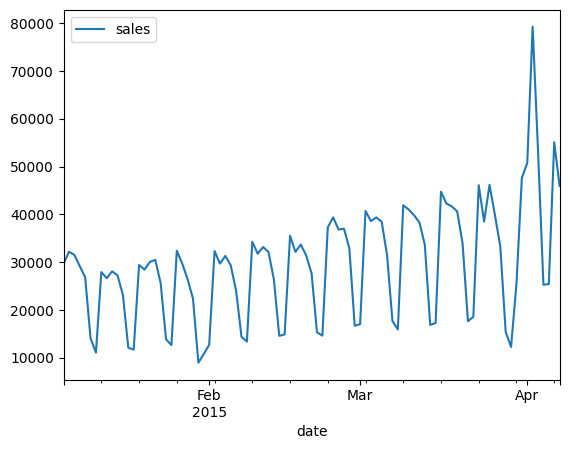

In [257]:
salesandcost_control.plot(x='date', y='sales')

### Split data into pre-test (train) and during intervention (test) data

In [290]:
train_df=pd.DataFrame()
train_df['y']= salesandcost_treatment[salesandcost_treatment['date']<='2015-02-15']['sales']
train_df['x']= salesandcost_control[salesandcost_control['date']<='2015-02-15']['sales']
train_df
test_df=pd.DataFrame()
test_df['y']= salesandcost_treatment[(salesandcost_treatment['date']>='2015-02-16') & (salesandcost_treatment['date']<='2015-03-15')]['sales']
test_df['x']= salesandcost_control[(salesandcost_control['date']>='2015-02-16')& (salesandcost_control['date']<='2015-03-15')]['sales']


### Model treatment (Y) as a function of control (X) using pre-test (train) data

In [291]:
import numpy as np 
import statsmodels.api as sm 
from sklearn.preprocessing import StandardScaler
# Standardize the predictor 'x' (train_df is assumed to be the dataset) 
scaler = StandardScaler() 
# X = train_df['x'].values.reshape(-1,1) 
X =scaler.fit_transform(train_df['x'].values.reshape(-1, 1)) 
X = sm.add_constant(X) # Add the intercept to the model

# X_test = test_df['x'].values.reshape(-1,1) 
X_test=scaler.transform(test_df['x'].values.reshape(-1, 1)) # Test data (use same scaler)
X_test = sm.add_constant(X_test) # Add intercept to the test data as well 

y_train = train_df['y'].values # Response variable 
y_test = test_df['y'].values # Response variable for test data
# Fit the linear regression model 
model = sm.OLS(y_train, X).fit()
#get predictions for test data
y_hat = model.predict(X_test) 
predictions = model.get_prediction(X_test) # Prediction results (mean and standard deviations) 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     7487.
Date:                Thu, 26 Sep 2024   Prob (F-statistic):           4.06e-47
Time:                        23:14:31   Log-Likelihood:                -327.14
No. Observations:                  42   AIC:                             658.3
Df Residuals:                      40   BIC:                             661.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.357e+04     92.367    255.151      0.000    2.34e+04    2.38e+04
x1          7992.0816     92.367     86.525      0.000    7805.400    8178.763
==============================================================================
Omnibus:                        2.320   Durbin-Watson:                   1.443
Prob(Omnibus):                  0.313   Jarque-Bera (JB):                1.336
Skew:                          -0.067   Prob(JB):                        0.513
Kurtosis:                       2.137   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Get daily sales prediction and sd of predicted sales

In [292]:
#Extracting Prediction Results:

#y.hat.sd: Standard deviation estimates of the mean predictions.
predictions_summary = predictions.summary_frame(alpha=0.05)  # 95% CI by default
y_hat_sd = predictions_summary['mean_se']

#sigma: The estimated standard deviation of the residuals (errors) of the linear model.
sigma = np.sqrt(model.scale)

y_pred_sd = (y_hat_sd**2 + sigma**2)**0.5  # Pointwise s.d. of the predictions.
y_pred_sd
y_pred_dif = y_test - y_hat

y_pred_sd

0     620.210562
1     613.011099
2     615.996207
3     611.714494
4     607.169666
5     613.883220
6     615.249833
7     624.924308
8     631.270971
9     623.624371
10    624.097529
11    614.412854
12    611.520509
13    610.971888
14    635.801017
15    628.820415
16    631.245974
17    628.367572
18    611.799789
19    610.072926
20    612.783672
21    640.113469
22    636.901120
23    632.758249
24    627.899503
25    615.878753
26    611.224803
27    610.623710
Name: mean_se, dtype: float64

### Cumulative variance calculation for (observed - predicted) data for treatment vs control

In [293]:
# Get the covariance matrix of the model 
covariance_matrix = model.cov_params() 
alpha_var = covariance_matrix[0, 0] # Variance of the intercept
covariance_matrix

array([[ 8.53171038e+03, -2.69445964e-13],
       [-2.69445964e-13,  8.53171038e+03]])

In [294]:
# Cumulative variance calculation for the test period 
x_test_values = scaler.transform(test_df['x'].values.reshape(-1, 1)) # The 'x' values from the test data
# x_test_values = test_df['x'].values.reshape(-1, 1)
x_seq = np.arange(1, len(x_test_values) + 1) # Sequence for the test period
# Calculate cumulative mean for the test data 
x_cum_mean = np.cumsum(x_test_values) / x_seq

In [295]:
# Compute cumulative variance of the predictions 
y_pred_var_cum_test=0
if covariance_matrix.shape[0] == 1:# Only intercept in the model 
    # y_pred_var_cum_test = alpha_var 
    y_pred_var_cum_test = (x_seq ** 2) * alpha_var 
else: # Intercept and slope case 
    beta_var = covariance_matrix[1, 1]   
    # Variance of the slope 
    alpha_beta_cov = covariance_matrix[0, 1] # Covariance between intercept and slope
    # Compute cumulative variance of predictions accounting for correlation 
    y_pred_var_cum_test = (x_seq ** 2) * ( alpha_var + (x_cum_mean ** 2) * beta_var + 2 * x_cum_mean * alpha_beta_cov )
    y_pred_sd_cum_test = (y_pred_var_cum_test + x_seq* sigma**2)**0.5  # Pointwise s.d. of the predictions.
# Output the cumulative variance for the test period 
print("Cumulative sd of predictions during the test period:", y_pred_sd_cum_test)
# Compute cumulative sum of prediction errors (optional) 
y_pred_dif_test = (y_test - y_hat) 
y_pred_dif_cum_sum = np.cumsum(y_pred_dif_test)
print("Cumulative sum of prediction differences:", y_pred_dif_cum_sum)

Cumulative sd of predictions during the test period: [ 620.21056242  895.93828485 1125.79332537 1323.26328986 1491.29726008
 1610.15223882 1730.3146679  1893.13691124 2065.4805127  2232.57713143
 2401.51136112 2552.68435184 2632.01634136 2716.03125918 2888.02336583
 3055.76273621 3230.00373371 3402.35741999 3538.71613465 3603.05722963
 3662.0522871  3844.75986437 4027.23955761 4206.30219111 4378.74834746
 4524.63364324 4572.59612378 4625.51366232]
Cumulative sum of prediction differences: [  5558.81805653  12594.70473275  18646.58222512  25288.89000317
  29908.47403598  31631.32544301  34465.79721315  39170.02559794
  45257.5577985   51832.70683819  58147.48713932  62690.20982289
  65571.88925825  68079.45459914  76488.43812871  83589.06925697
  91096.60915445  98483.80633833 104811.66987805 108024.7712823
 111340.78417054 116836.96435905 123408.23100428 128758.71838462
 135019.07970789 140406.030416   143160.22629173 147337.12168451]


### Calculating P-value for analysis
#####     y(obs) 

In [249]:
# calculating tail probability (p-value)
print(model.df_resid)
t.sf((0-y_pred_dif_cum_sum)/y_pred_var_cum_test**0.5,df=model.df_resid)

40.0


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])